# Lecture 1c: Unsupervised Learning and Clustering Approaches
This lecture introduces the first unsupervised learning approaches we will explore: k-means clustering and self-organizing maps. We will use these algorithms to identify hidden patterns and structures in data without explicit guidance.

The key concepts covered in this lecture include:
* __Unsupervised learning__: is a type of machine learning that involves training algorithms on unlabeled data. Unsupervised learning aims to identify patterns and structures in data without explicit guidance. 
Unsupervised learning is particularly useful when dealing with large volumes of unstructured data or when the desired outcomes are unknown.}
* __Clustering__: is a typical unsupervised learning technique that involves dividing a dataset into distinct groups, or clusters, based on the similarity of data points. 
Clustering algorithms aim to group data points that are more similar to each other than to those in different clusters.
* __K-means clustering__ is a popular and straightforward clustering algorithm that partitions a dataset into $k$ clusters. 
The algorithm iteratively assigns data points to the nearest cluster center and updates the cluster centers based on the mean of the assigned points.
* __Self-organizing maps (SOMs)__: are another unsupervised learning algorithm that uses a neural network to map high-dimensional data onto a lower-dimensional grid.

Lecture notes can be found: [here!](docs/Notes.pdf)

## Prerequisites
We set up the computational environment by including the `Include.jl` file and then load any needed resources. Finally, we end by setting up any required constants. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem.

In [3]:
include("Include.jl")

cluster (generic function with 1 method)

In this lecture, we'll work with a [customer spending preferences dataset from Kaggle](https://www.kaggle.com/code/heeraldedhia/kmeans-clustering-for-customer-data?select=Mall_Customers.csv). This dataset was created learning customer segmentation concepts, known as [market basket analysis](https://en.wikipedia.org/wiki/Market_basket). We will demonstrate the unsupervised ML technique: k-means clustering analysis.

In [5]:
originaldataset = CSV.read(joinpath(_PATH_TO_DATA, "mall-customers-dataset.csv"), DataFrame)

Row,id,gender,age,income,spendingscore
,Int64,String7,Int64,Int64,Int64
1,1,Male,19,15,39
2,2,Male,21,15,81
3,3,Female,20,16,6
4,4,Female,23,16,77
5,5,Female,31,17,40
6,6,Female,22,17,76
7,7,Female,35,18,6
8,8,Female,23,18,94
9,9,Male,64,19,3


Let's remap the `gender::String7` column to a number, i.e., let `Male = -1` and `Female = 1.` It's much easier to use numbers than categorical data when looking at (and analyzing) this data later. We'll store the revised dataset in [the `dataset::DataFrame` variable](https://github.com/JuliaData/DataFrames.jl).

In [7]:
dataset = let
    treated_dataset = copy(originaldataset);
    transform!(treated_dataset, :gender => ByRow( x-> (x=="Male" ? -1 : 1)) => :gender);
    treated_dataset 
end;

In [8]:
dataset

Row,id,gender,age,income,spendingscore
,Int64,Int64,Int64,Int64,Int64
1,1,-1,19,15,39
2,2,-1,21,15,81
3,3,1,20,16,6
4,4,1,23,16,77
5,5,1,31,17,40
6,6,1,22,17,76
7,7,1,35,18,6
8,8,1,23,18,94
9,9,-1,64,19,3


### Visualize
What does this data look like? Let's plot different data views to see what we can see, e.g., are there obvious patterns or groups in the dataset?
* `Unhide` the code block below to see how we plotted the dataset using [the `Plots.jl` package](https://github.com/JuliaPlots/Plots.jl), and particularly the [`scatter(...)` function](https://docs.juliaplots.org/stable/api/#Plots.scatter-Tuple). An initial look at the data (`income` versus `spendingscore`) suggests that there are perhaps at least five groups (clusters) in the data. However, the groupings in other views, e.g., `age` versus `spendingscore` are not as obvious.

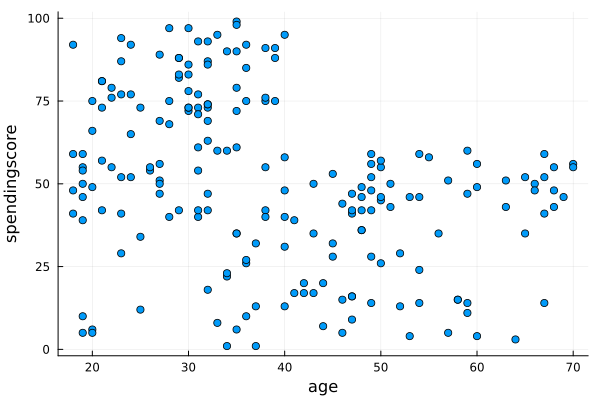

In [10]:
let
    horizontal_column = :age
    vertical_column = :spendingscore

    scatter(dataset[:, horizontal_column], dataset[:, vertical_column], label="")
    xlabel!("$(String(horizontal_column))");
    ylabel!("$(String(vertical_column))");
end

### Constants
Let's set some constants that we'll need in the examples below. See the comment next to the constant for a description of what it is, it's permissible values, etc.

In [12]:
n = nrow(dataset); # how many example data points do we have?
m = 4; # number of features
maxiter = 1000; # maximum iterations
K = 5; # number of clusters
ϵ = 0.01; # tolerance for termination

setup the color dictionary for the visualizations in the lecture:

In [14]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#003049";
my_color_dictionary[2] = colorant"#d62828";
my_color_dictionary[3] = colorant"#f77f00";
my_color_dictionary[4] = colorant"#fcbf49";
my_color_dictionary[5] = colorant"#eae2b7";

## What is unsupervised learning?
Fill me in

## K-means clustering
The K-means algorithm, originally developed by [Lloyd in the 1950s but not published until much later in 1982](https://ieeexplore.ieee.org/document/1056489), is our first example of $\texttt{unsupervised learning}$. 
K-means is a popular unsupervised machine learning algorithm for clustering data points into a distinct set of groups (clusters) $\mathcal{C} = \left\{\mathcal{c}_{1},\dots,\mathcal{c}_{K}\right\}$ based on _similarity_.

__Key idea__
* __Initialization__. You give the data set $\mathbf{x}\in\mathcal{D}$, which contains `n` data vectors (measurements, observations, etc) $\mathbf{x}_{1},\dots,\mathbf{x}_{n}$ where each vector $\mathbf{x}_{i}$ has `m` features, and the number and (initial) locations of K-clusters to the algorithm. Each cluster $\mathcal{c}_{k}$ is represented by a centroid, i.e., the mean of the set of data points in the cluster $\left\{\mathbf{x}_{i}\right\}_{i\in\mathcal{c}_{k}}$. In the K-means approach, you have to tell the algorithm how many clusters and the initial location of each cluster. This initial guess is then iteratively refined.
* __Iteration__. The K-means algorithm employs an iterative process wherein data points are assigned to the nearest cluster centroid, and the centroids are subsequently updated based on the mean of the assigned points. This iterative process continues until a predetermined stopping criterion is satisfied.
* __Stopping__. There are several ways the K-means algorithm can terminate. The stopping criteria for the K-means clustering algorithm include when the cluster centroids do not change significantly, when data points remain in the same clusters across iterations, or when a maximum number of iterations is reached.

#### Implementation
Now that we understand the basics of the algorithm, let's sketch a pseudo-code implementation and then translate that into an actual implementation. We'll then use this implementation to explore our customer dataset.

<img src="figs/pcode-kmeans.png" alt="drawing" width="800"/>

We've developed a [initial k-means implementation](src/Cluster.jl) using the pseudo-code. Let's explore this implementation on our sample dataset. 
* First, let's build [a `MyNaiveKMeansClusteringAlgorithm` instance](src/Types.jl), which holds information about the clustering, i.e., `K` the number of clusters, and some information about the dataset such as the number of features `m`, and the number of points `n`, etc. we'll save this model in the `model::MyNaiveKMeansClusteringAlgorithm` variable.

In [20]:
model = build(MyNaiveKMeansClusteringAlgorithm, (
        maxiter = maxiter,
        dimension = m,
        number_of_points = n,
        K = K,
        ϵ = ϵ,
));

Fill me in about what is in the model

In [22]:
model.assigments

200-element Vector{Int64}:
 5
 3
 2
 1
 2
 3
 3
 3
 5
 2
 4
 4
 4
 ⋮
 3
 4
 1
 3
 2
 2
 3
 5
 4
 2
 3
 4

#### Visualize the initial centroids and assignments
Fill me in

In [24]:
M = Matrix(dataset)[:,2:end] # exclude the id field
result = cluster(M, model)

([2, 4, 2, 4, 2, 4, 2, 4, 2, 4  …  5, 3, 5, 3, 5, 3, 5, 3, 5, 3], Dict(5 => [-0.02702702702702703, 40.32432432432432, 87.43243243243244, 18.18918918918919], 4 => [0.12, 24.96, 28.04, 77.0], 2 => [0.21739130434782608, 45.21739130434783, 26.304347826086957, 20.91304347826087], 3 => [0.07692307692307693, 32.69230769230769, 86.53846153846153, 82.12820512820512], 1 => [0.18421052631578946, 43.93421052631579, 55.21052631578947, 49.44736842105263]))

In [25]:
result[1]

200-element Vector{Int64}:
 2
 4
 2
 4
 2
 4
 2
 4
 2
 4
 2
 4
 2
 ⋮
 5
 3
 5
 3
 5
 3
 5
 3
 5
 3
 5
 3

In [45]:
findfirst(x-> x == "gender", names(dataset))

2

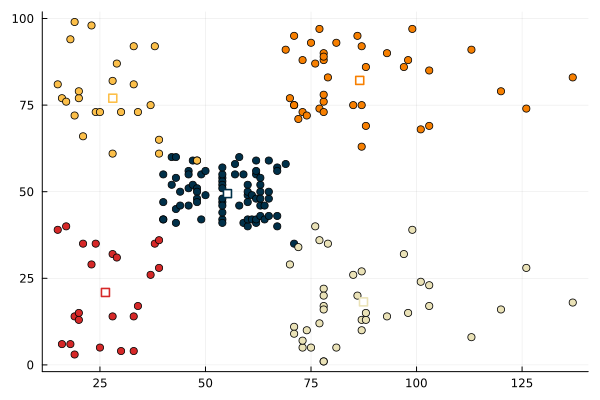

In [71]:
let

    p = plot(); # make an empty plot
    horizontal_column = :income
    vertical_column = :spendingscore
    horizontal_index = findfirst(x-> x == String(horizontal_column), names(dataset)) - 1; # correct for the id col
    vertical_index = findfirst(x-> x == String(vertical_column), names(dataset)) - 1; # correct for the id col
    
    assignments = result[1];
    for i ∈ eachindex(assignments);
        a = assignments[i];        
        scatter!([dataset[i, horizontal_column]], [dataset[i, vertical_column]], label="", c=my_color_dictionary[a]);
    end
    current();

    # plot the centroids -
    centroids = result[2];
    for k ∈ 1:K
        c = centroids[k]
        scatter!([c[horizontal_index]], [c[vertical_index]], label="", msc=my_color_dictionary[k], c="white", ms=4, markerstrokewidth=2, 
            markershape=:square)
    end
    current();
end